In [4]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Load datasets
uber_df = pd.read_csv('/kaggle/input/uber-fares-dataset/uber.csv')
weather_df = pd.read_csv('/kaggle/input/weather/weather.csv')


In [5]:
# Step 3: Convert timestamps
uber_df['pickup_datetime'] = pd.to_datetime(uber_df['pickup_datetime'], errors='coerce')
weather_df['time'] = pd.to_datetime(weather_df['time'], errors='coerce')


### 🕒 Step 3: Convert Columns to Datetime Format

Before any time-based operations, we need to ensure that the timestamp columns in both datasets are correctly recognized as datetime objects.

- **Uber dataset**: The `pickup_datetime` column is converted to `datetime` format using `pd.to_datetime`.  
- **Weather dataset**: The `time` column is also converted to `datetime` format similarly.

We use the `errors='coerce'` parameter to handle any invalid date formats gracefully by converting them into `NaT` (Not a Time).


In [6]:
# Step 4: Drop missing or invalid timestamps
uber_df = uber_df.dropna(subset=['pickup_datetime'])
weather_df = weather_df.dropna(subset=['time'])

In [7]:
# Uber data
uber_df['pickup_datetime'] = pd.to_datetime(uber_df['pickup_datetime'])
uber_df['datetime_hour'] = uber_df['pickup_datetime'].dt.floor('h')  # lowercase 'h'

# Weather data
weather_df['time'] = pd.to_datetime(weather_df['time'])
weather_df['datetime_hour'] = weather_df['time'].dt.floor('h')  # lowercase 'h'

### 🕓 Step 4: Normalize Timestamps to the Hour


To align Uber trip data with hourly weather data, we convert the timestamps in both datasets to the nearest hour. This is done by creating a new column `datetime_hour` in each dataset:

- **Uber dataset**:  
  We extract the hour part from `pickup_datetime` using the `.dt.floor('h')` method.

- **Weather dataset**:  
  Similarly, we extract the hour part from `time` using the same method.

This prepares both datasets for merging based on matching hourly timestamps.


In [8]:
# Ensure datetime columns are timezone-naive in both dataframes
uber_df['datetime_hour'] = uber_df['datetime_hour'].dt.tz_localize(None)
weather_df['datetime_hour'] = weather_df['datetime_hour'].dt.tz_localize(None)

### ⏱️ Step 5: Remove Timezone Information from Datetime Columns

To ensure a smooth merge between the Uber and Weather datasets, we must make sure their datetime columns are **timezone-naive** (i.e., without any timezone information). This is essential because merging datetime columns with differing timezone types (`datetime64[ns, UTC]` vs `datetime64[ns]`) can result in errors.

> This step ensures consistency in timestamp formats before merging.


In [9]:
merged_df = pd.merge(uber_df, weather_df, on='datetime_hour', how='left')

In [10]:
merged_df.drop(['datetime', 'pickup_datetime'], axis=1, inplace=True, errors='ignore')

In [11]:
print(merged_df.columns)

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'datetime_hour', 'time', 'temperature_2m (°C)',
       'relative_humidity_2m (%)', 'dew_point_2m (°C)', 'rain (mm)',
       'snowfall (cm)', 'precipitation (mm)', 'pressure_msl (hPa)',
       'weather_code (wmo code)', 'apparent_temperature (°C)',
       'wind_speed_10m (km/h)', 'snow_depth (m)', 'cloud_cover (%)'],
      dtype='object')


In [12]:
# Rename weather columns to simple names
merged_df = merged_df.rename(columns={
    'temperature_2m (°C)': 'temperature',
    'relative_humidity_2m (%)': 'humidity',
    'dew_point_2m (°C)': 'dew_point',
    'rain (mm)': 'rain',
    'snowfall (cm)': 'snowfall',
    'precipitation (mm)': 'precipitation',
    'pressure_msl (hPa)': 'pressure',
    'weather_code (wmo code)': 'weather_code',
    'apparent_temperature (°C)': 'apparent_temp',
    'wind_speed_10m (km/h)': 'wind_speed',
    'snow_depth (m)': 'snow_depth',
    'cloud_cover (%)': 'cloud_cover'
})

In [13]:
# Basic info and summary
print(merged_df.info())
print(merged_df.describe())

# Check for remaining missing values
missing = merged_df.isnull().sum()
print("Missing values:\n", missing)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Unnamed: 0         200000 non-null  int64         
 1   key                200000 non-null  object        
 2   fare_amount        200000 non-null  float64       
 3   pickup_longitude   200000 non-null  float64       
 4   pickup_latitude    200000 non-null  float64       
 5   dropoff_longitude  199999 non-null  float64       
 6   dropoff_latitude   199999 non-null  float64       
 7   passenger_count    200000 non-null  int64         
 8   datetime_hour      200000 non-null  datetime64[ns]
 9   time               187216 non-null  datetime64[ns]
 10  temperature        187216 non-null  float64       
 11  humidity           187216 non-null  float64       
 12  dew_point          187216 non-null  float64       
 13  rain               187216 non-null  float64 

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


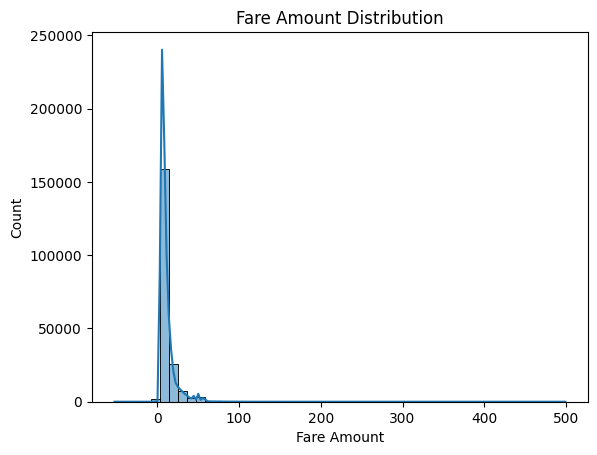

In [14]:
# Plot fare distribution
sns.histplot(merged_df['fare_amount'], bins=50, kde=True)
plt.title("Fare Amount Distribution")
plt.xlabel("Fare Amount")
plt.show()

# Remove extreme or invalid values (if any)
merged_df = merged_df[(merged_df['fare_amount'] > 0) & (merged_df['fare_amount'] < 200)]
merged_df = merged_df[(merged_df['passenger_count'] > 0) & (merged_df['passenger_count'] <= 6)]

In [15]:
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # Earth radius in km
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a)) 
    return R * c

merged_df['distance_km'] = merged_df.apply(lambda row: haversine(
    row['pickup_longitude'], row['pickup_latitude'],
    row['dropoff_longitude'], row['dropoff_latitude']
), axis=1)

# Remove trips with 0 or extremely high distance
merged_df = merged_df[(merged_df['distance_km'] > 0) & (merged_df['distance_km'] < 100)]


### 📏 Step 6: Calculate Trip Distance Using the Haversine Formula

To analyze trip fares effectively, we need to compute the distance between pickup and drop-off locations. We'll use the **Haversine formula**, which calculates the great-circle distance between two points on a sphere using their latitude and longitude.

#### Why Haversine?
Because Earth is a sphere (not flat), using this formula provides more accurate results than a simple Euclidean calculation.

We also filter out records with **zero or extremely high distances** (above 100 km), which are likely data errors or outliers.


In [16]:
merged_df['hour'] = merged_df['datetime_hour'].dt.hour
merged_df['day'] = merged_df['datetime_hour'].dt.day
merged_df['weekday'] = merged_df['datetime_hour'].dt.weekday  # 0 = Monday
merged_df['month'] = merged_df['datetime_hour'].dt.month


In [17]:
merged_df['log_fare'] = np.log1p(merged_df['fare_amount'])  # log(1+fare)
merged_df['log_distance'] = np.log1p(merged_df['distance_km'])


In [18]:
final_features = [
    'passenger_count', 'distance_km', 'hour', 'weekday', 'month',
    'temperature', 'humidity', 'dew_point', 'rain', 'snowfall',
    'precipitation', 'pressure', 'apparent_temp'
]

# Drop rows with any remaining missing values in selected features
model_df = merged_df[final_features + ['fare_amount']].dropna()

print(model_df.head())


   passenger_count  distance_km  hour  weekday  month  temperature  humidity  \
0                1     1.683323    19        3      5         23.7      44.0   
1                1     2.457590    20        4      7         27.5      56.0   
2                1     5.036377    21        0      8         27.7      49.0   
3                3     1.661683     8        4      6         19.1      95.0   
4                5     4.475450    17        3      8         26.5      41.0   

   dew_point  rain  snowfall  precipitation  pressure  apparent_temp  \
0       10.8   0.0       0.0            0.0    1021.2           24.2   
1       18.0   0.0       0.0            0.0    1008.6           28.7   
2       16.2   0.0       0.0            0.0    1017.3           28.5   
3       18.3   0.0       0.0            0.0    1006.6           21.0   
4       12.2   0.0       0.0            0.0    1012.1           26.3   

   fare_amount  
0          7.5  
1          7.7  
2         12.9  
3          5.3  
4

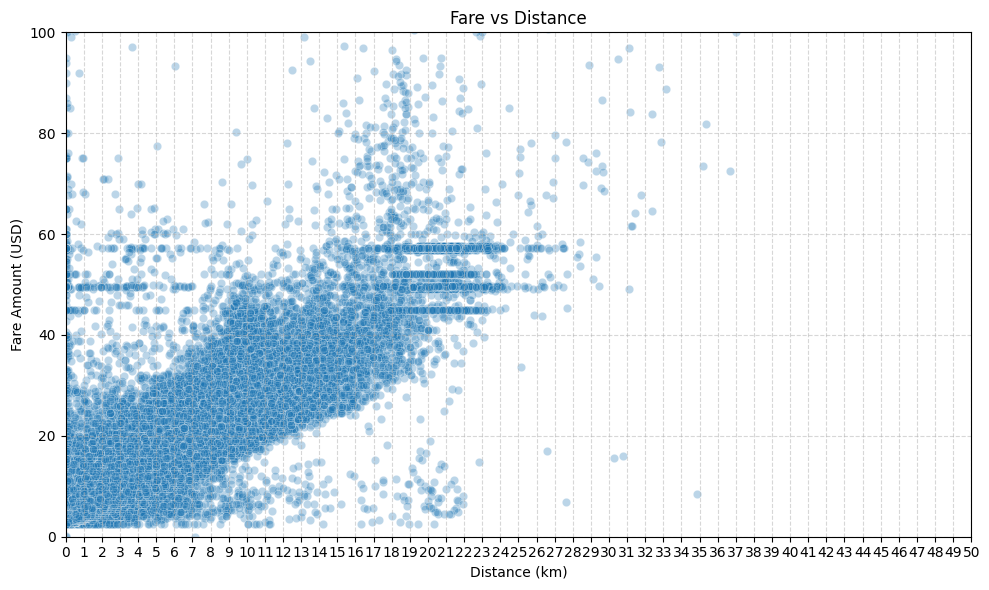

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='distance_km', y='fare_amount', alpha=0.3)

plt.title("Fare vs Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Fare Amount (USD)")

plt.gca().xaxis.set_major_locator(MultipleLocator(1))  # Ticks every 1 km
plt.xlim(0, 50)  # Optional: zoom into a specific range if needed
plt.ylim(0, 100)  # Optional: remove extreme outliers

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


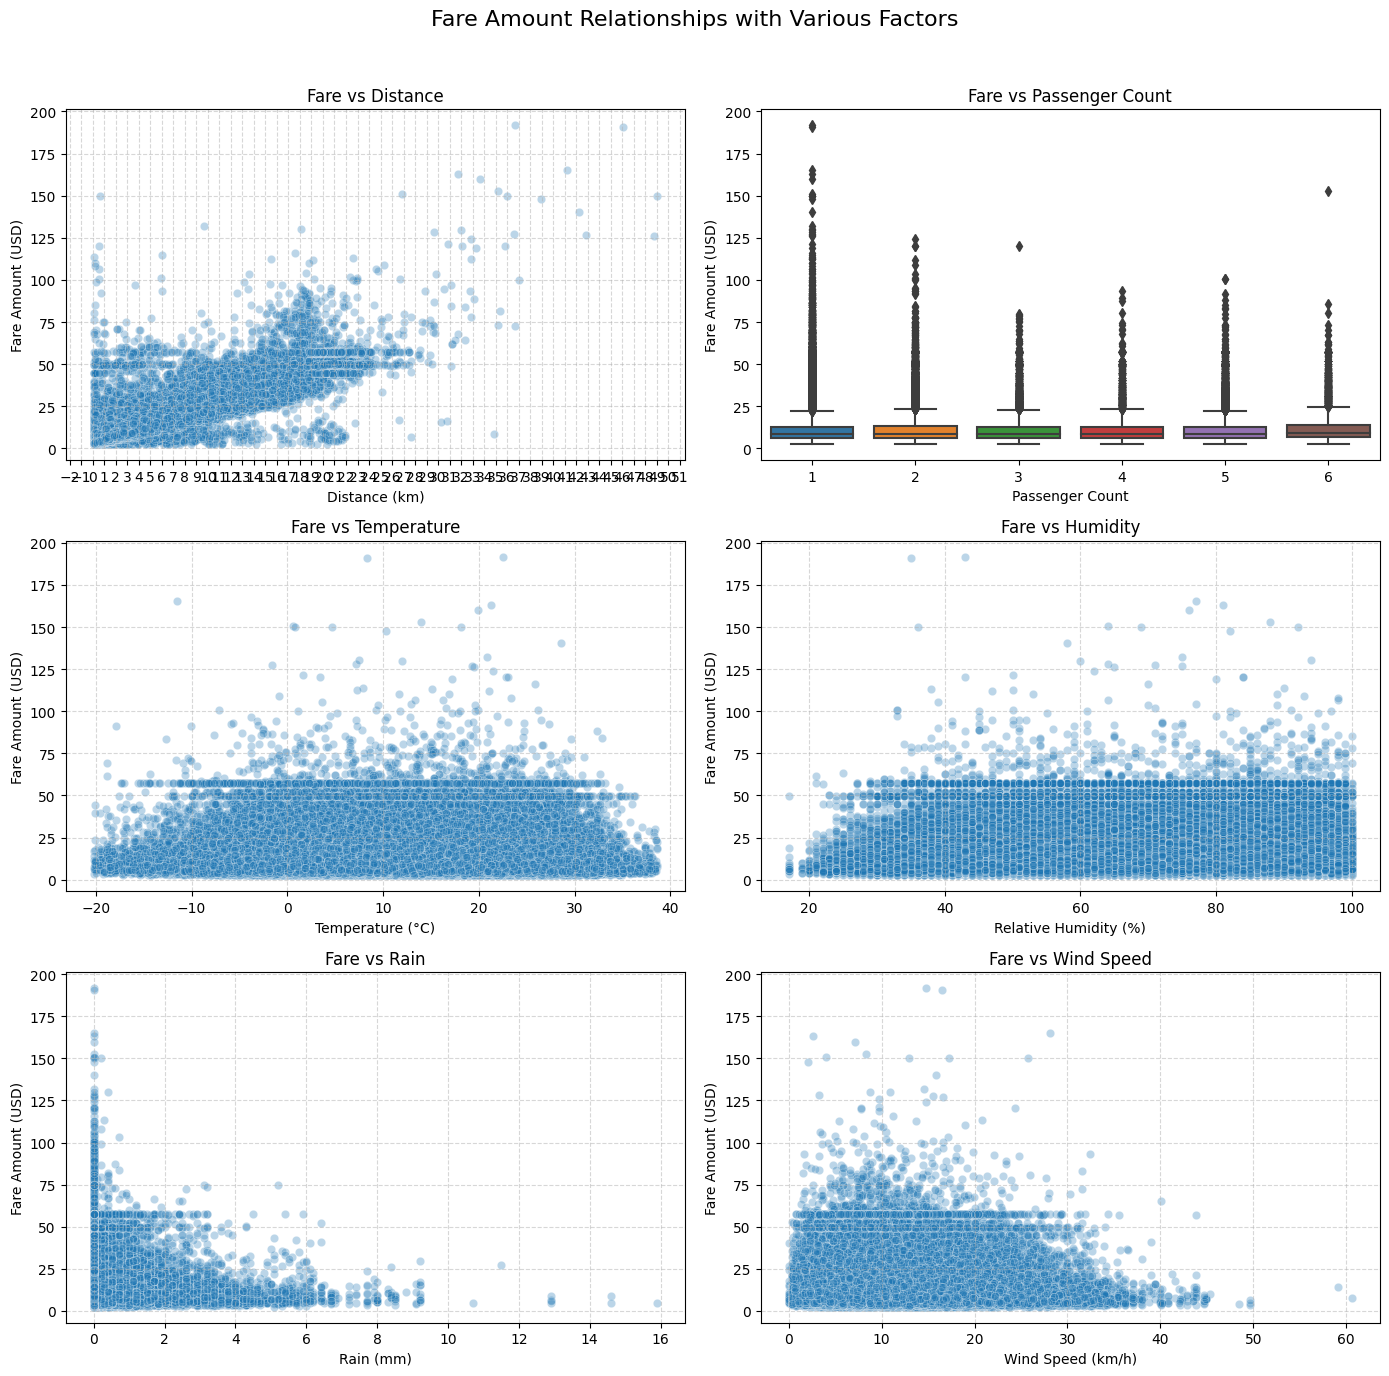

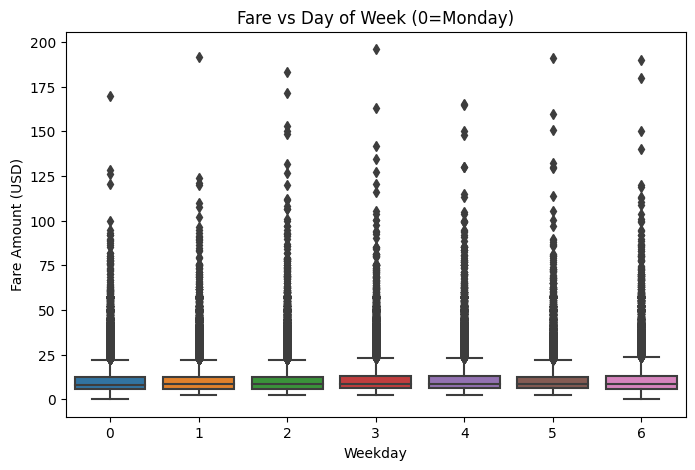

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator

# Step 1: Clean data (remove outliers)
clean_df = merged_df[
    (merged_df['fare_amount'] > 2) & (merged_df['fare_amount'] < 200) &
    (merged_df['distance_km'] > 0.1) & (merged_df['distance_km'] < 50) &
    (merged_df['passenger_count'] >= 1) & (merged_df['passenger_count'] <= 6)
].copy()

# Step 2: Setup plotting grid for 6 plots
fig, axes = plt.subplots(3, 2, figsize=(14, 14))
fig.suptitle("Fare Amount Relationships with Various Factors", fontsize=16)

# Plot 1: Fare vs Distance
sns.scatterplot(ax=axes[0, 0], data=clean_df, x='distance_km', y='fare_amount', alpha=0.3)
axes[0, 0].set_title("Fare vs Distance")
axes[0, 0].set_xlabel("Distance (km)")
axes[0, 0].set_ylabel("Fare Amount (USD)")
axes[0, 0].xaxis.set_major_locator(MultipleLocator(1))
axes[0, 0].grid(True, linestyle='--', alpha=0.5)

# Plot 2: Fare vs Passenger Count
sns.boxplot(ax=axes[0, 1], data=clean_df, x='passenger_count', y='fare_amount')
axes[0, 1].set_title("Fare vs Passenger Count")
axes[0, 1].set_xlabel("Passenger Count")
axes[0, 1].set_ylabel("Fare Amount (USD)")

# Plot 3: Fare vs Temperature
sns.scatterplot(ax=axes[1, 0], data=clean_df, x='temperature', y='fare_amount', alpha=0.3)
axes[1, 0].set_title("Fare vs Temperature")
axes[1, 0].set_xlabel("Temperature (°C)")
axes[1, 0].set_ylabel("Fare Amount (USD)")
axes[1, 0].grid(True, linestyle='--', alpha=0.5)

# Plot 4: Fare vs Humidity
sns.scatterplot(ax=axes[1, 1], data=clean_df, x='humidity', y='fare_amount', alpha=0.3)
axes[1, 1].set_title("Fare vs Humidity")
axes[1, 1].set_xlabel("Relative Humidity (%)")
axes[1, 1].set_ylabel("Fare Amount (USD)")
axes[1, 1].grid(True, linestyle='--', alpha=0.5)

# Plot 5: Fare vs Rain
sns.scatterplot(ax=axes[2, 0], data=clean_df, x='rain', y='fare_amount', alpha=0.3)
axes[2, 0].set_title("Fare vs Rain")
axes[2, 0].set_xlabel("Rain (mm)")
axes[2, 0].set_ylabel("Fare Amount (USD)")
axes[2, 0].grid(True, linestyle='--', alpha=0.5)

# Plot 6: Fare vs Wind Speed
sns.scatterplot(ax=axes[2, 1], data=clean_df, x='wind_speed', y='fare_amount', alpha=0.3)
axes[2, 1].set_title("Fare vs Wind Speed")
axes[2, 1].set_xlabel("Wind Speed (km/h)")
axes[2, 1].set_ylabel("Fare Amount (USD)")
axes[2, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Now Plot 7 separately ---
# Ensure 'weekday' column exists, create if not:
if 'weekday' not in merged_df.columns:
    merged_df['weekday'] = merged_df['datetime_hour'].dt.dayofweek  # Monday=0, Sunday=6

plt.figure(figsize=(8,5))
sns.boxplot(data=merged_df, x='weekday', y='fare_amount')
plt.title("Fare vs Day of Week (0=Monday)")
plt.xlabel("Weekday")
plt.ylabel("Fare Amount (USD)")
plt.show()


In [21]:

# Define thresholds for outlier removal
fare_min, fare_max = 2, 200          # fare_amount in USD
distance_min, distance_max = 0.1, 50 # distance in km
passenger_min, passenger_max = 1, 6  # number of passengers (typical taxi limits)

# Apply filter conditions
filtered_df = merged_df[
    (merged_df['fare_amount'] >= fare_min) & (merged_df['fare_amount'] <= fare_max) &
    (merged_df['distance_km'] >= distance_min) & (merged_df['distance_km'] <= distance_max) &
    (merged_df['passenger_count'] >= passenger_min) & (merged_df['passenger_count'] <= passenger_max)
].copy()

print(f"Original dataset size: {merged_df.shape}")
print(f"Filtered dataset size: {filtered_df.shape}")


Original dataset size: (193188, 29)
Filtered dataset size: (191999, 29)


### 🧹 Step 7: Remove Outliers for Cleaner Modeling

To build a reliable model, it's crucial to remove outliers that can skew the analysis. We apply filters based on:

- **Fare Amount**: Must be between \$2 and \$200.
- **Distance**: Between 0.1 km and 50 km (extremely long/short trips excluded).
- **Passenger Count**: Between 1 and 6 (typical for most NYC taxis).

This filtering helps retain only **realistic trips**, improving both model accuracy and training stability.


Correlation with Fare Amount:
fare_amount        1.000000
distance_km        0.898116
pressure           0.021113
passenger_count    0.013592
humidity           0.008272
snow_depth         0.004777
dew_point          0.004501
apparent_temp      0.001585
temperature        0.000235
snowfall          -0.003361
cloud_cover       -0.004742
rain              -0.007200
precipitation     -0.007766
wind_speed        -0.013228
Name: fare_amount, dtype: float64


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


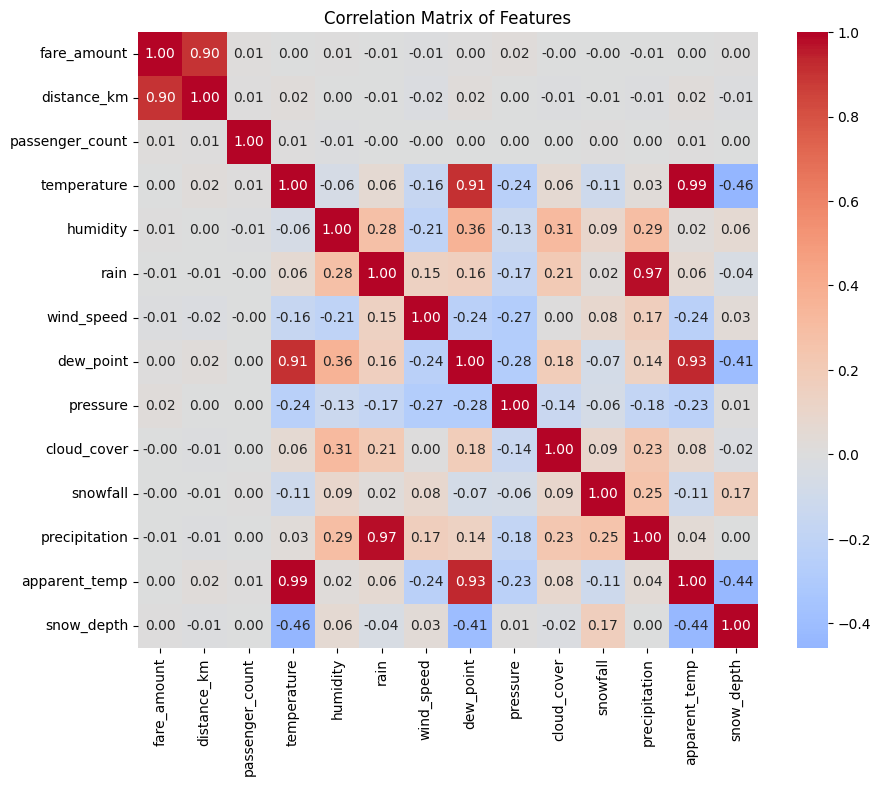

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant numeric columns for correlation
corr_features = [
    'fare_amount', 'distance_km', 'passenger_count',
    'temperature', 'humidity', 'rain', 'wind_speed',
    'dew_point', 'pressure', 'cloud_cover', 'snowfall',
    'precipitation', 'apparent_temp', 'snow_depth'
]

# Use cleaned dataframe for correlation
corr_df = clean_df[corr_features].copy()

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Show correlation of features with 'fare_amount'
print("Correlation with Fare Amount:")
print(corr_matrix['fare_amount'].sort_values(ascending=False))

# Plot heatmap for full correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Features")
plt.show()


### 📊 Step 8: Correlation Analysis

To understand how different variables influence **fare amount**, we perform a correlation analysis on selected numeric features.

- We use `Pearson correlation` to evaluate linear relationships.
- This helps identify **which features are strongly or weakly correlated** with the target variable (`fare_amount`).
- Highly correlated features can guide **feature selection** for model training.

Below we print the correlation values with `fare_amount` and visualize all relationships using a heatmap.


In [23]:
merged_df.to_csv('uber_fares_merged.csv', index=False)

In [24]:
# Save cleaned dataset to CSV
clean_df.to_csv('uber_fares_cleaned.csv', index=False)

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------------
# Load dataset
df = pd.read_csv("/kaggle/working/uber_fares_merged.csv")

# Drop unnecessary columns (ignore if not present)
df = df.drop(columns=["Unnamed: 0", "key", "time", "log_fare", "log_distance"], errors="ignore")

# -------------------------------
# Check for nulls and remove them
df = df.dropna(subset=[
    "pickup_longitude", "pickup_latitude", 
    "dropoff_longitude", "dropoff_latitude",
    "fare_amount", "hour", "day", "weekday", "month"
])

# -------------------------------
# Define final features
final_features = [
    "pickup_longitude", "pickup_latitude", 
    "dropoff_longitude", "dropoff_latitude",
    "hour", "day", "weekday", "month"
]

# Prepare X and y
X = df[final_features]
y = df["fare_amount"]

# -------------------------------
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------

In [26]:
# Linear Regression
lr_model = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=-1)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
lr_mae = mean_absolute_error(y_test, lr_preds)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_r2 = r2_score(y_test, lr_preds)

print("Linear Regression Performance:")
print(f"  MAE: {lr_mae:.3f}")
print(f"  RMSE: {lr_rmse:.3f}")
print(f"  R2 Score: {lr_r2:.3f}\n")


Linear Regression Performance:
  MAE: 6.014
  RMSE: 12.148
  R2 Score: -0.607



In [28]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(
    n_estimators=700,
    criterion='squared_error',
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=10,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)

print("Random Forest Performance:")
print(f"  MAE: {rf_mae:.3f}")
print(f"  RMSE: {rf_rmse:.3f}")
print(f"  R2 Score: {rf_r2:.3f}\n")


Random Forest Performance:
  MAE: 3.053
  RMSE: 4.821
  R2 Score: 0.747



In [32]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
gb_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.5,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=10,
    subsample=1.0,
    max_features=None,
    random_state=42
)
gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_test)
gb_mae = mean_absolute_error(y_test, gb_preds)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_preds))
gb_r2 = r2_score(y_test, gb_preds)

print("Gradient Boosting Performance:")
print(f"  MAE: {gb_mae:.3f}")
print(f"  RMSE: {gb_rmse:.3f}")
print(f"  R2 Score: {gb_r2:.3f}\n")


Gradient Boosting Performance:
  MAE: 2.212
  RMSE: 4.202
  R2 Score: 0.808



In [40]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize results dictionary
results = {}

# Define and train the XGBoost model
xgb_model = XGBRegressor(
    n_estimators=5000,
    learning_rate=0.05,
    max_depth=5,
    subsample=1.0,
    colsample_bytree=0.8,
    min_child_weight=1,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

# Make predictions
xgb_preds = xgb_model.predict(X_test)

# Evaluate performance
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_r2 = r2_score(y_test, xgb_preds)

# Save results
results['XGBoost'] = {
    'MAE': xgb_mae,
    'RMSE': xgb_rmse,
    'R2': xgb_r2
}

# Display performance
print("✅ XGBoost Performance:")
print(f"  MAE: {xgb_mae:.6f}")
print(f"  RMSE: {xgb_rmse:.6f}")
print(f"  R² Score: {xgb_r2:.6f}")


✅ XGBoost Performance:
  MAE: 1.990256
  RMSE: 4.133773
  R² Score: 0.813921


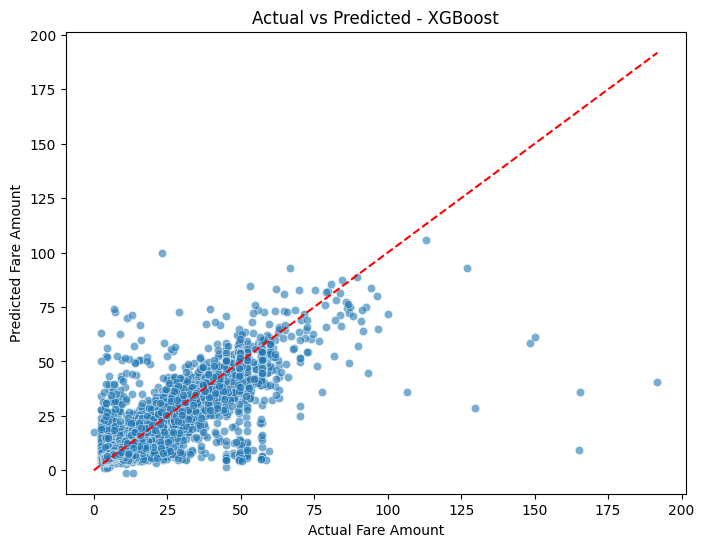

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=xgb_preds, alpha=0.6)
plt.xlabel("Actual Fare Amount")
plt.ylabel("Predicted Fare Amount")
plt.title("Actual vs Predicted - XGBoost")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


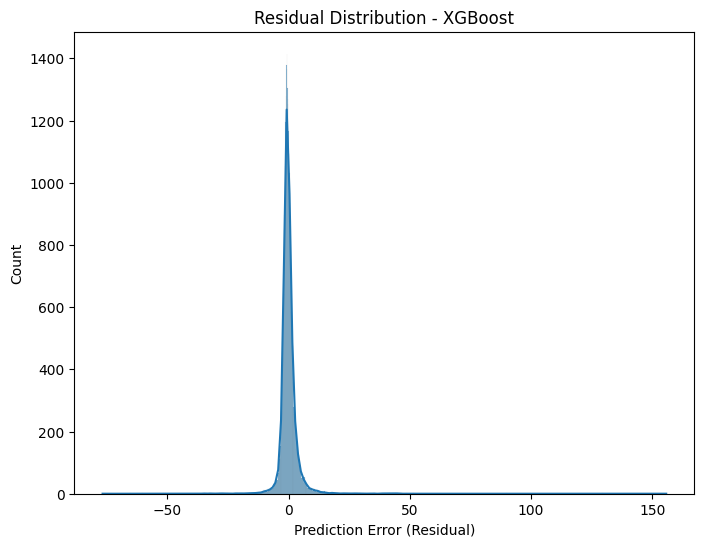

In [42]:
residuals = y_test - xgb_preds

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel("Prediction Error (Residual)")
plt.title("Residual Distribution - XGBoost")
plt.show()


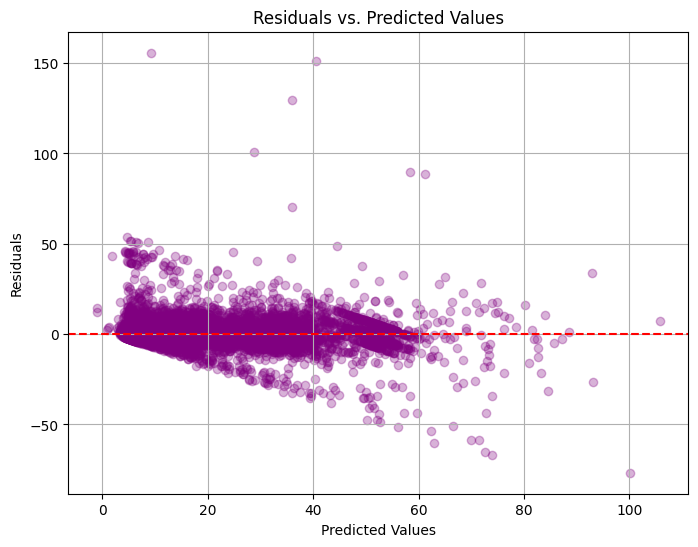

In [43]:
plt.figure(figsize=(8, 6))
plt.scatter(xgb_preds, residuals, alpha=0.3, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.grid(True)
plt.show()


In [44]:
# Comparing Models
results = {
    "Linear Regression": {"MAE": lr_mae, "RMSE": lr_rmse, "R2": lr_r2},
    "Random Forest": {"MAE": rf_mae, "RMSE": rf_rmse, "R2": rf_r2},
    "XGBoost": {"MAE": xgb_mae, "RMSE": xgb_rmse, "R2": xgb_r2},
    "Gradient Boosting": {"MAE": gb_mae, "RMSE": gb_rmse, "R2": gb_r2}
    
}

best_model_name = min(results, key=lambda x: results[x]['RMSE'])
print(f"✅ Best model based on RMSE: {best_model_name}")


✅ Best model based on RMSE: XGBoost


In [59]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------
# Step 1: Load and clean data
df = pd.read_csv("/kaggle/working/uber_fares_merged.csv")

# Drop missing or invalid coordinates and datetime
df = df.dropna(subset=['pickup_latitude', 'pickup_longitude', 'datetime_hour'])
df = df[(df['pickup_latitude'].between(40, 42)) & (df['pickup_longitude'].between(-75, -72))]

# ----------------------------------
# Step 2: Convert datetime column
df['datetime_hour'] = pd.to_datetime(df['datetime_hour'])
df['hour'] = df['datetime_hour'].dt.hour
df['weekday'] = df['datetime_hour'].dt.weekday
df['month'] = df['datetime_hour'].dt.month

# ----------------------------------
# Step 3: Cluster coordinates into zones
kmeans = KMeans(n_clusters=20, random_state=42, n_init='auto')

coords = df[['pickup_latitude', 'pickup_longitude']]
kmeans = KMeans(n_clusters=20, random_state=42)
df['zone_id'] = kmeans.fit_predict(coords)

# Optional: Assign zone names A, B, C, ...
zone_names = {i: chr(65 + i) for i in range(26)}  # up to 26 zones
df['zone_name'] = df['zone_id'].map(zone_names)

# ----------------------------------
# Step 4: Count trips per zone per time
grouped = df.groupby(['zone_id', 'hour', 'weekday', 'month']).size().reset_index(name='trip_count')
grouped['trip_probability'] = grouped['trip_count'] / grouped['trip_count'].sum()

# ----------------------------------
# Step 5: Prepare features and train model
X = grouped[['zone_id', 'hour', 'weekday', 'month']]
y = grouped['trip_probability']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# ----------------------------------
# Step 6: Prediction function
def predict_top_zones(input_datetime_str, top_n=5):
    dt = pd.to_datetime(input_datetime_str)
    hour = dt.hour
    weekday = dt.weekday()
    month = dt.month
    
    # Create prediction input for all zones
    all_zone_ids = grouped['zone_id'].unique()
    predict_df = pd.DataFrame({
        'zone_id': all_zone_ids,
        'hour': hour,
        'weekday': weekday,
        'month': month
    })

    # Predict probabilities
    predict_df['predicted_prob'] = model.predict(predict_df)
    predict_df = predict_df.sort_values(by='predicted_prob', ascending=False).head(top_n)

    # Add coordinates and zone names for display
    zone_centers = pd.DataFrame(kmeans.cluster_centers_, columns=['lat', 'lon'])
    predict_df['zone_name'] = predict_df['zone_id'].map(zone_names)
    predict_df[['lat', 'lon']] = predict_df['zone_id'].apply(lambda z: zone_centers.iloc[z]).apply(pd.Series)

    print("🔝 Top Predicted Zones:")
    print(predict_df[['zone_name', 'predicted_prob']])

    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=zone_centers, x='lon', y='lat', label='All Zones', color='gray')
    sns.scatterplot(data=predict_df, x='lon', y='lat', hue='zone_name', palette='tab10', s=200)
    plt.title(f"Top {top_n} Trip Generation Zones for {input_datetime_str}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.legend()
    plt.show()



/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


🔝 Top Predicted Zones:
   zone_name  predicted_prob
13         N        0.000104
8          I        0.000100
3          D        0.000092
11         L        0.000087
0          A        0.000080


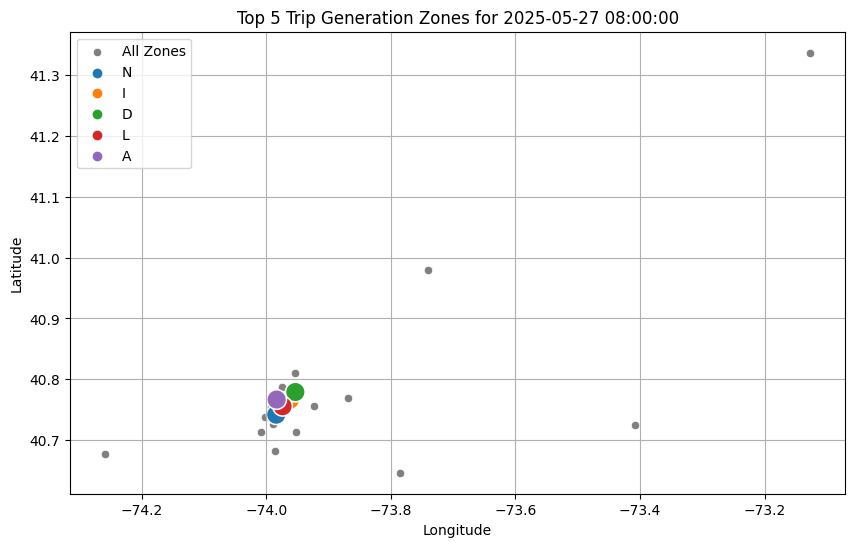

In [55]:
# ----------------------------------
# Example usage
predict_top_zones("2025-05-27 08:00:00")
